In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt 
import seaborn as sns

from typing import Optional, Tuple


import tqdm

tfd = tfp.distributions

In [2]:
#Load dataset
df = pd.read_csv('../input/winecsv/wine.csv')
df.head()



,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,3
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


Look at the frequencies of each class

[Text(0, 0.5, '%'), Text(0.5, 0, 'Type of wine')]

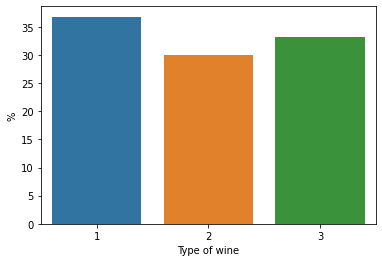

In [3]:
sns.barplot(x="type",y="type",data=df,
            estimator=lambda x: len(x) / len(df.type) * 100).set(ylabel="%",xlabel="Type of wine")

Classes are balanced

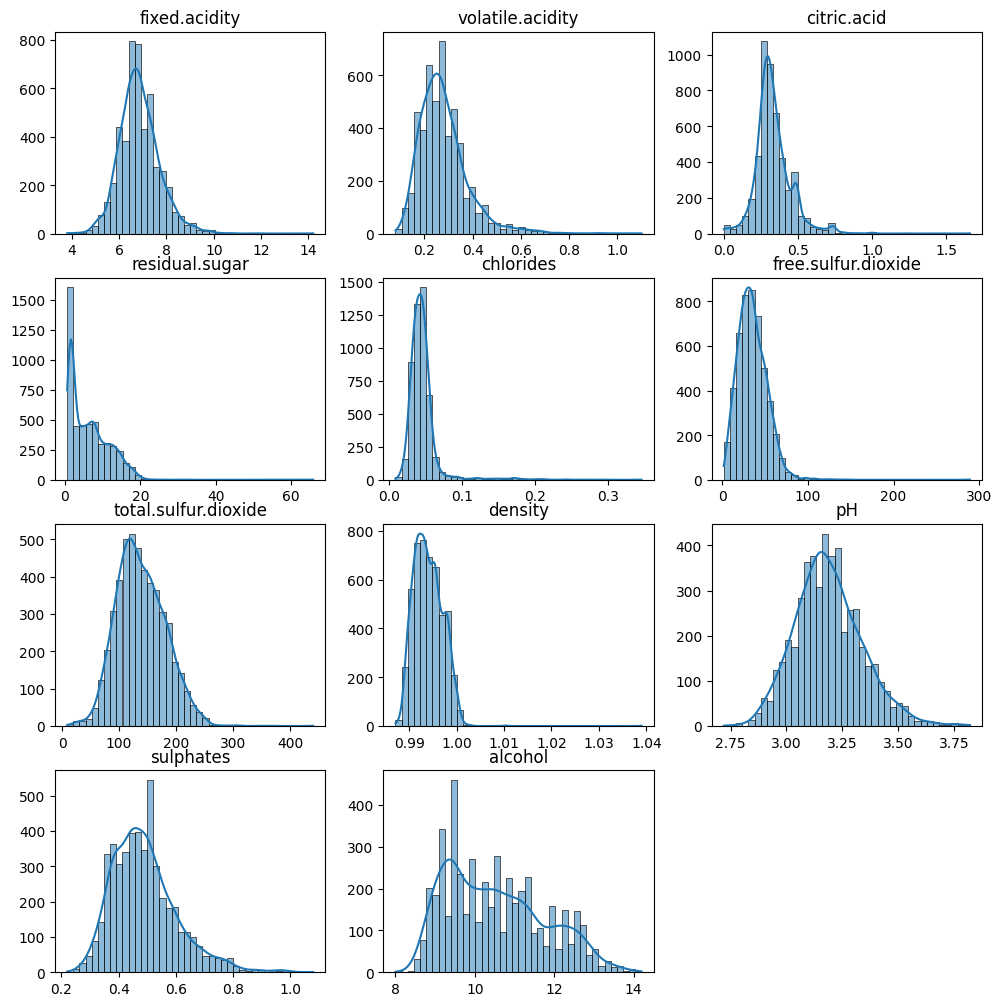

In [4]:
#Further exploration of variables

number_of_variables = df.shape[1] -2
n_subplot_rows = 3
n_subplot_cols = (number_of_variables + 1) // n_subplot_rows
fig, ax = plt.subplots(4, 3, figsize=(10,10), dpi=100)
fig.tight_layout()

features = pd.DataFrame(df.iloc[:-2],columns=df.columns.values[:-2])

for i in range(4):
    for j in range(3):
        idx = 3*i +j
        if idx< number_of_variables:
            sns.histplot(features.iloc[:,idx],ax=ax[i][j],bins=40,kde='True')
            ax[i,j].set(xlabel=None)
            ax[i,j].set(ylabel=None)
            ax[i,j].title.set_text('{}'.format(df.columns.values[idx]))
        else:
            ax[i, j].axis('off')


In [5]:
#Convert quality to float
y=df.iloc[:,-2].astype(float).values
X=df.iloc[:,:-2]

#Standarization of features (extremely important for PCA, LDA, SVM,...)
from sklearn.preprocessing import StandardScaler
esc=StandardScaler()
X_esc = esc.fit_transform(X)

In [6]:
def scatter_2d_label_with_subset(X_2d, y,subset, ax=None, s=0.5, alpha=0.85, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
        
    subset : ndarray
        subset of points to be flagged on the plot
    """
    
    targets = np.unique(y)# extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
        
    ax.scatter(X_2d[subset, 0],X_2d[subset, 1],color='black')
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

[0.29293217 0.14320363]


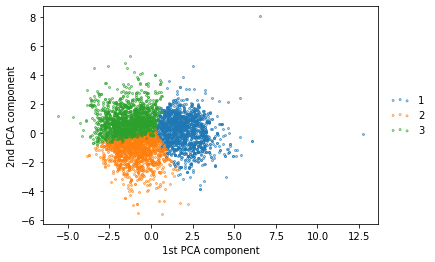

In [7]:
# PCA : Assesss variables' relevance
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_esc)
print(pca.explained_variance_ratio_)
#pca.components_

y=df['type'].values.reshape(-1)
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_pca, y, ax=ax,subset=[])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');



Classes appear to be properly separated. At first glance we might even assume that our data are linearly separable!!

We split our data into training and validation in order to validate our baseline (non-Bayesian) models. We will use the whole dataset to train our Bayesian neural network (BNN).

In [8]:
#Hold out a test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-2],df.iloc[:,-1],random_state=2,test_size=0.25)


from sklearn.preprocessing import OneHotEncoder
y_train_onehot = OneHotEncoder(sparse=False).fit_transform(y_train.values.reshape(-1,1)) 
y_test_onehot = OneHotEncoder(sparse=False).fit_transform(y_test.values.reshape(-1,1)) 

In [9]:
#Standarization (extremely important for PCA, LDA, SVM,...)
from sklearn.preprocessing import StandardScaler
esc=StandardScaler()
X_train = esc.fit_transform(X_train)
X_test= esc.fit_transform(X_test)

### Softmax regression (baseline)

Accuracy on train set: 1.0
Accuracy on test set: 0.9926530612244898

[[453   0   0]
 [  4 371   1]
 [  1   3 392]]


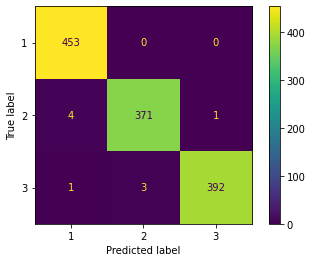

In [10]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=500)
logreg.fit(X_train,y_train)


y_pred=logreg.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score,zero_one_loss,confusion_matrix,precision_score,plot_confusion_matrix
print('Accuracy on train set: '+str(accuracy_score(y_train,logreg.predict(X_train))))
print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred))+"\n")
#precision_score(y_test,y_pred)
#f1_score(y_test,y_pred)
#zero_one_loss(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))

plot_confusion_matrix(logreg,X_test,y_test)


Note that we may confidently use accuracy as metric since the classes are not heavily unbalanced

In [11]:
#k-NN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

print('Accuracy on train set: '+str(accuracy_score(y_train,knn.predict(X_train))))
print('Accuracy on test set: '+str(accuracy_score(y_test,knn.predict(X_test)))+"\n")

y_pred=knn.predict(X_test)

accuracy_score(y_test,y_pred)

Accuracy on train set: 0.9667846447046011
Accuracy on test set: 0.9420408163265306



0.9420408163265306

In [12]:
#SVM
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train,y_train)

y_pred=svc.predict(X_test)

print('Accuracy on train set: '+str(accuracy_score(y_train,knn.predict(X_train))))
print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred))+"\n")



confusion_matrix(y_test,y_pred)

Accuracy on train set: 0.9667846447046011
Accuracy on test set: 0.976326530612245



array([[448,   3,   2],
       [  6, 365,   5],
       [  5,   8, 383]])

So far, we have seen that a simple softmax regression yields an accuracy larger than 99% on the test set

### Vanilla NN

Train a baseline non-Bayesian NN

In [13]:
batch = X_train.shape[0]

vanilla_model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1])),
        layers.Dense(6, activation="relu"),
        layers.Dense(3, activation = 'softmax')
    ]
)

n_epochs=500
vanilla_model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy',metrics=['accuracy'])
vanilla_history=vanilla_model.fit(X_train, y_train_onehot, batch_size=batch ,
                                  epochs=n_epochs,verbose=0,validation_data=(X_test,y_test_onehot))

[Text(0.5, 0, 'Epoch')]

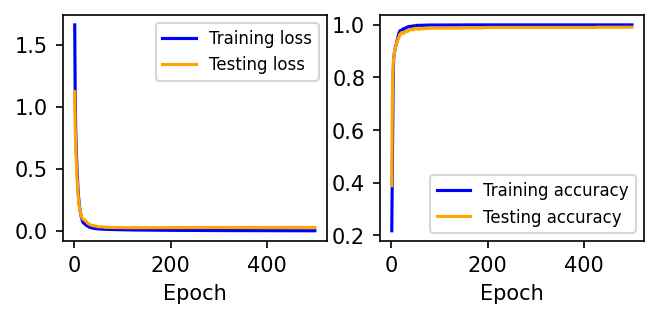

In [14]:
#print(vanilla_history.history.keys())
fig, ax = plt.subplots(1, 2, figsize=(5,2), dpi=150)

#"Loss"
sns.lineplot(x=1+np.arange(n_epochs), y=vanilla_history.history['loss'],ax=ax[0],color='blue')
sns.lineplot(x=1+np.arange(n_epochs), y=vanilla_history.history['val_loss'],ax=ax[0],color='orange')
ax[0].legend(['Training loss','Testing loss'],fontsize=8)
ax[0].set(xlabel='Epoch')

#"MSE"'
sns.lineplot(x=1+np.arange(n_epochs), y=vanilla_history.history['accuracy'],ax=ax[1],color='blue')
sns.lineplot(x=1+np.arange(n_epochs), y=vanilla_history.history['val_accuracy'],ax=ax[1],color='orange')
ax[1].legend(['Training accuracy','Testing accuracy'],fontsize=8)
ax[1].set(xlabel='Epoch')

The baseline model does not seem to overfit (nor underfit)

In [15]:
from sklearn.metrics import accuracy_score,f1_score,zero_one_loss,confusion_matrix,precision_score,plot_confusion_matrix

print('Accuracy on train set: '+str(accuracy_score(np.argmax(y_train_onehot,axis=1),
                                                   np.argmax(vanilla_model.predict(X_train),axis=1))))
      
print('Accuracy on test set: '+str(accuracy_score(np.argmax(y_test_onehot,axis=1),
                                                   np.argmax(vanilla_model.predict(X_test),axis=1))))


#Show confusion matrix (on test set)
p = vanilla_model.predict(X_test)                    # Fitted values (outputs predicted from training inputs)
confusion_matrix(np.argmax(y_test_onehot, axis=1),  # Input class membership
                 np.argmax(p, axis=1))  # Output class membership

Accuracy on train set: 1.0
Accuracy on test set: 0.9910204081632653


array([[453,   0,   0],
       [  4, 370,   2],
       [  1,   4, 391]])

### Full BNN

Use the whole dataset to train the model

In [16]:
#Convert quality to float
y_train=df.iloc[:,-1].astype(float).values
y_test=y_train
X=df.iloc[:,:-2]

esc = StandardScaler()

X_train = esc.fit_transform(X)
X_test = X_train


from sklearn.preprocessing import OneHotEncoder
y_train_onehot = OneHotEncoder(sparse=False).fit_transform(y_train.reshape(-1,1)) 
y_test_onehot = y_train_onehot 


In [17]:
'''
We consider a similar architecture as before. There is hidden DenseFlipout layers
(see https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout) with
the same number of nodes as in the non-Bayesian setting. The output is also a DenseFlipout layer
with a linear activation i.e. it returns the logits, not probabilities in [0,1]

We use an ELBO loss function (defined below)
'''

# We need to scale our Kullback-Leibler (KL) divergence with the inverse of the batch size
# (see Keras documentation)

batch_size = X_train.shape[0]
def kl_divergence_function(q,p,_):
    return tfd.kl_divergence(q, p) /tf.cast(batch_size, dtype=tf.float32)

from keras import backend as K
# Build model.
bnn_model = tf.keras.Sequential([
    
  # Define a logistic regression model as a Bernoulli distribution
  # parameterized by logits from a single linear layer. We use the Flipout
  # Monte Carlo estimator for the layer: this enables lower variance
  # stochastic gradients than naive reparameterization.
    
  tf.keras.layers.Input(shape=X_train.shape[1]),
  tf.keras.layers.BatchNormalization(),
  tfp.layers.DenseFlipout(
      units=6,
      activation='relu',
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      kernel_divergence_fn=kl_divergence_function),
    
  tfp.layers.DenseFlipout(
      units=3,
      activation='linear',
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      kernel_divergence_fn=kl_divergence_function),

 
])


def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.OneHotCategorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(y_true))
def loss(y_true,y_pred,model=bnn_model):
    nll = neg_log_likelihood_with_logits(y_true,y_pred)
    kl = tf.reduce_sum(model.losses, axis=-1)
    return kl + nll


# Do inference.
n_epochs=500
#full_model.compile(optimizer=Adam(learning_rate=0.01), loss=negloglik,metrics=['accuracy'])
bnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=loss ,metrics=['accuracy'])

#model.fit(x=X, y=y, epochs=300, batch_size=batch, verbose = 0)
bnn_history=bnn_model.fit(X_train, y_train_onehot, batch_size=X_train.shape[0],verbose=0 ,epochs=n_epochs)



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


[Text(0.5, 0, 'Epoch')]

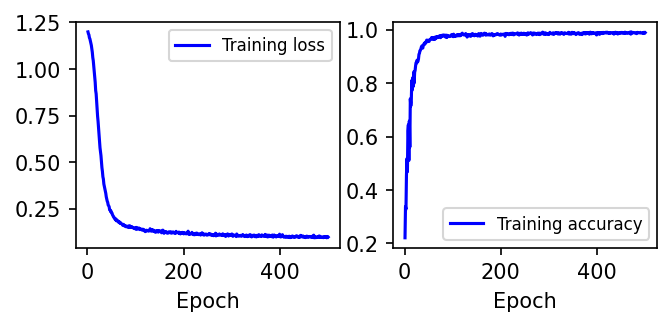

In [18]:
#print(vanilla_history.history.keys())
fig, ax = plt.subplots(1, 2, figsize=(5,2), dpi=150)

#"Loss"
sns.lineplot(x=1+np.arange(n_epochs), y=bnn_history.history['loss'],ax=ax[0],color='blue')
#sns.lineplot(x=1+np.arange(n_epochs), y=bnn_history.history['val_loss'],ax=ax[0],color='orange')
ax[0].legend(['Training loss','Testing loss'],fontsize=8)
ax[0].set(xlabel='Epoch')

#"MSE"'
sns.lineplot(x=1+np.arange(n_epochs), y=bnn_history.history['accuracy'],ax=ax[1],color='blue')
#sns.lineplot(x=1+np.arange(n_epochs), y=bnn_history.history['val_accuracy'],ax=ax[1],color='orange')
ax[1].legend(['Training accuracy','Testing accuracy'],fontsize=8)
ax[1].set(xlabel='Epoch')

In [19]:
# MC sampling to approximate the posterior predictive distribution
from scipy.special import softmax
MC_samples=1000
y_pred_list = []
y_pred_list_logits = []
for i in tqdm.tqdm(range(MC_samples)):
    y_pred = bnn_model.predict(X_test)
    y_pred_list.append(softmax(y_pred,axis=1))
    y_pred_list_logits.append(y_pred)
    

100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


In [20]:
#Calculate the mean, standard deviation, median and -log of the highest probability
pred_mean=np.mean(y_pred_list,axis=0)
pred_median = np.median(y_pred_list,axis=0)
sd = np.std(y_pred_list,axis=0)
NLL = -np.log(np.max(pred_mean,axis=1))

from sklearn.metrics import accuracy_score,f1_score,zero_one_loss,confusion_matrix,precision_score,plot_confusion_matrix


print('Accuracy on test set: '+str(accuracy_score(np.argmax(y_test_onehot,axis=1),
                                                   np.argmax(pred_mean,axis=1))))

# Fitted values (outputs predicted from training inputs)
confusion_matrix(np.argmax(y_test_onehot, axis=1),  # Input class membership
                 np.argmax(pred_mean, axis=1))  # Output class membership



Accuracy on test set: 0.9989791751735402


array([[1800,    1,    1],
       [   2, 1465,    1],
       [   0,    0, 1628]])

In [21]:
# This function plots the posterior predictive distribution of an observation. Note that we need to plot three distributions at a time
# as we have four classes

def plot_pred_hist(y_pred, sample , n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(20, 7)):
    pred_matrix = np.zeros((MC_samples,n_class))
    for i in range(MC_samples):
        pred_matrix[i,] = y_pred[i][sample,]
        
    
    print('\nmean of predicted probs = \n', np.mean(pred_matrix,axis=0))
    print('True label: '+str(y_test[sample]))
    print('Mean standard deviation = '+str(round(np.mean(np.std(pred_matrix,axis=0)),2)))
    print('Post. pred. entropy = '+str(round( -np.sum([p*np.log(p) for p in np.mean(pred_matrix,axis=0)]) ,2)))


    figsize=(20, 7)
    bins = np.logspace(-n_bins, 0, n_bins+1)
    n_subplot_cols = (n_class + 1) // n_subplot_rows
    fig, ax = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=figsize, dpi=100)
    
    
    for i in range(n_subplot_rows):
        for j in range(n_subplot_cols):
            idx = i * n_subplot_cols + j
            if idx < n_class:
                #ax[i, j].hist(pred_matrix[:,idx], bins)
                sns.histplot(pred_matrix[:,idx],ax=ax[i][j],bins=n_bins,legend=True)
                
                heights = [ax[i][j].patches[p].get_height() for p in range(len(ax[i][j].patches))]
                data_mean = pd.DataFrame({'x':[np.mean(pred_matrix[:,idx])]*2,
                                           'y':[0,1.25*np.max(heights)]})
                
                for _ in range(7):#Get a brighter straight line by plotting several times
                    sns.lineplot(data=data_mean,x='x',y='y', color='red',ax=ax[i][j],legend='auto')
                #ax[i, j].set_xscale('log')
                ax[i,j].legend(['Mean'])
                ax[i,j].set_xlabel(('Probability'))
                #ax[i, j].set_ylim([0, n_mc_run/5])
                ax[i, j].title.set_text("{} (Mean prob: {:.2f}) (std: {:.2f}) ({})".format(str(idx),
                                                                               np.mean(pred_matrix[:,idx]),
                                                                               np.std(pred_matrix[:,idx]),
                                                                               str(np.mean(pred_matrix[:,idx]) >= 0.2)))
               
            else:
                ax[i, j].axis('off')
    fig.subplots_adjust(hspace=0.4)
    plt.show()


mean of predicted probs = 
 [0.00425322 0.99095264 0.00479414]
True label: 2.0
Mean standard deviation = 0.01
Post. pred. entropy = 0.06


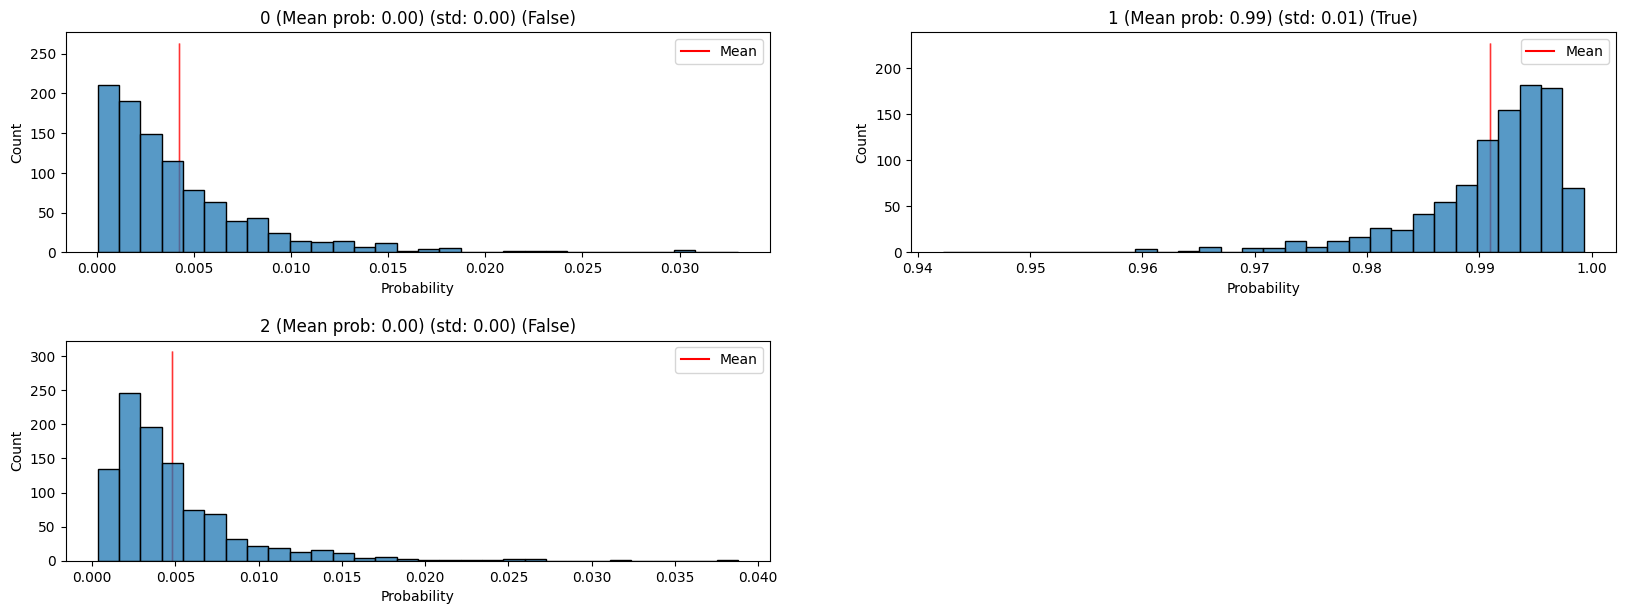

In [22]:
plot_pred_hist(y_pred = y_pred_list,
              sample = 321,
              n_class = 3,
              n_mc_run=MC_samples)

## Mutual information + entropy

In [23]:
#Calculate entropy
n_classes = 3
y_mean = np.mean(y_pred_list,axis=0)
y_median = np.median(y_pred_list,axis=0)

S=np.zeros((X_test.shape[0],))
for i in range(X_test.shape[0]):
    for c in range(n_classes):
        if y_mean[i,c]==0:
            pass
        else:
            S[i] -= y_mean[i,c]*np.log2(y_mean[i,c])

In [24]:
#Calculate mutual information
I = np.zeros((X_test.shape[0],))
for i in range(X_test.shape[0]):
    if i%500==0: 
        print('Percentage completed: '+str(round(100*i/X_test.shape[0],2)))
    summation = 0
    for sample in range(MC_samples):
        for c in range(n_classes):
            p = y_pred_list[sample][i,c]
            if  p==0:
                summation -= 0
            else:
                summation -= p*np.log2(p)
    
    I[i] = S[i] - summation/MC_samples  

Percentage completed: 0.0
Percentage completed: 10.21
Percentage completed: 20.42
Percentage completed: 30.62
Percentage completed: 40.83
Percentage completed: 51.04
Percentage completed: 61.25
Percentage completed: 71.46
Percentage completed: 81.67
Percentage completed: 91.87


Plot the histograms of the entropy and the mutual information

<AxesSubplot:ylabel='Count'>

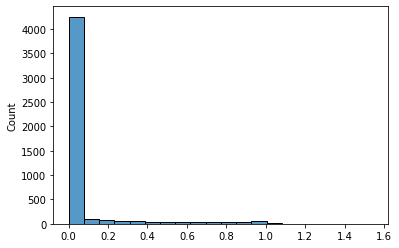

In [25]:
sns.histplot(S,bins=20)

<AxesSubplot:ylabel='Count'>

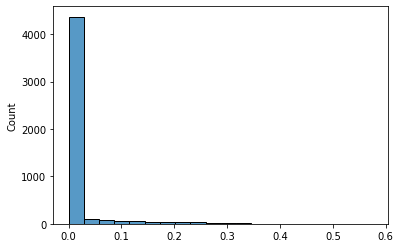

In [26]:
sns.histplot(I,bins=20)

Flag points with largest entropy

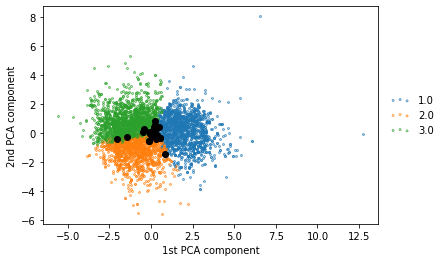

In [27]:
# PCA : Assesss variables' relevance
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)

#What upper quantile of the std distribution shall we take to achieve maximum accuracy at labelling accuracies (comparing with LOC)
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(X_test)

y=y_test.reshape(-1)
fig, ax = plt.subplots()
#Flag points with highest entropy
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(-S)[:30])
#scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(-np.mean(logits_sd,axis=1))[:100])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');

Points with smallest entropy

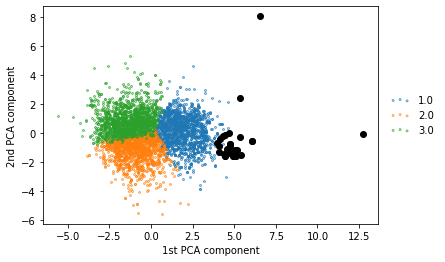

In [28]:
fig, ax = plt.subplots()
#Flag points with lowest entropy
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(S)[:30])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');

The two outliers are confidently classified (small entroy). Our model does not seem to capture epistemic uncertainty. It does, however, explain aleatoric uncertainty (sample between classes with large entropy.

Standard deviation shows the same behaviour as entropy

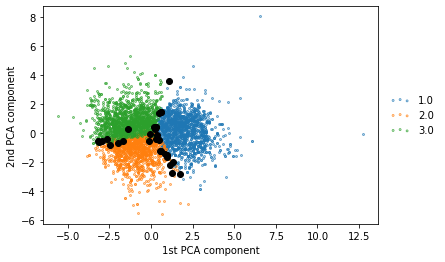

In [29]:
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(-np.mean(sd,axis=1))[:30])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');

### Get predictions

In [30]:
mislabelling = []
only_one = []
more_than_one = []
none = []
n_classes=3
prediction = np.zeros((X_test.shape[0],n_classes))

variance_matrix = np.zeros((X_test.shape[0],n_classes))
threshold = 0.2 ## Set a threshold of 20%


for i in range(X_test.shape[0]):
    #matrix = np.zeros((MC_samples,n_classes))
    argmax = []
    for sample in range(MC_samples):
        argmax.append(np.argmax(y_pred_list[sample][i,]))
    argmax = np.array(argmax)
    
    indexes=[idx for idx in range(n_classes) if len(argmax[argmax==idx])/MC_samples > threshold]
    for c in range(n_classes):
        variance_matrix[i,c] = len(argmax[argmax==c])/MC_samples*(1-len(argmax[argmax==c])/MC_samples)
    #prediction.append(indexes)
    
    for c in range(n_classes):
        if len(argmax[argmax==c])/MC_samples > threshold:
            prediction[i,c] = 1
    
    if len(indexes)==1:
        only_one.append(i)
        if y_test[i]!=indexes[0]:
            mislabelling.append(i) 
    else:
        if len(indexes)==0:
            none.append(i)
        more_than_one.append(i)
        mislabelling.append(i)

In [31]:
print('Threshold imposed: '+str(threshold)+"\n")
print('Percentage of unconfidently labelled samples (i.e. more than one outcome): ' 
      +str(round(100*len(more_than_one)/y_test.shape[0],2))+" %"+"  (There are "+str(len(more_than_one))+")"+"\n")
print('Percentage of non-labelled samples: ' +str(round(100*len(none)/y_test.shape[0],2))+" %"+"\n")

print('------------------------------------------------'+"\n")
print('Accuracy on whole test set (naively): '+str(round(100*accuracy_score(np.argmax(pred_mean,axis=1),
                                                                            np.argmax(y_test_onehot,axis=1)),2))+" %"+"\n")


print('Accuracy on confidently labelled samples (i.e. only one outcome): ' 
      +str(round(100*accuracy_score(prediction.astype(int)[only_one,],y_test_onehot[only_one]),2))+" %"+"\n")

print('Accuracy on unconfidently labelled samples (i.e. more than one outcome, return the most probable): '+str(round(100*accuracy_score(np.argmax(pred_mean[more_than_one],axis=1),
               np.argmax(y_test_onehot[more_than_one],axis=1)),2))+" %"+"\n")

print('------------------------------------------------'+"\n")

print('Precision on whole test set (naively): '+str(round(100*precision_score(np.argmax(pred_mean,axis=1),
                                                                            np.argmax(y_test_onehot,axis=1),average='weighted'),2))+" %"+"\n")


print('Precision on confidently labelled samples (i.e. only one outcome): ' 
      +str(round(100*precision_score(prediction.astype(int)[only_one,],y_test_onehot[only_one],average='weighted'),2))+" %"+"\n")

print('Precision on unconfidently labelled samples (i.e. more than one outcome, return the most probable): '+str(round(100*precision_score(np.argmax(pred_mean[more_than_one],axis=1),
               np.argmax(y_test_onehot[more_than_one],axis=1),average='weighted'),2))+" %"+"\n")



Threshold imposed: 0.2

Percentage of unconfidently labelled samples (i.e. more than one outcome): 2.23 %  (There are 109)

Percentage of non-labelled samples: 0.0 %

------------------------------------------------

Accuracy on whole test set (naively): 99.9 %

Accuracy on confidently labelled samples (i.e. only one outcome): 100.0 %

Accuracy on unconfidently labelled samples (i.e. more than one outcome, return the most probable): 95.41 %

------------------------------------------------

Precision on whole test set (naively): 99.9 %

Precision on confidently labelled samples (i.e. only one outcome): 100.0 %

Precision on unconfidently labelled samples (i.e. more than one outcome, return the most probable): 95.56 %



Higher entropy coincides with more than one output and with high uncertainty

### Have a look at LOF

In [32]:
#What upper quantile of the std distribution shall we take to achieve maximum accuracy at labelling accuracies (comparing with LOC)
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(X_test)

LocalOutlierFactor()

<AxesSubplot:>

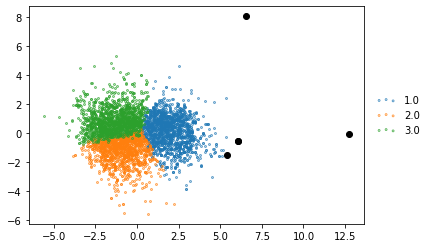

In [33]:
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(S)[:5])

<AxesSubplot:>

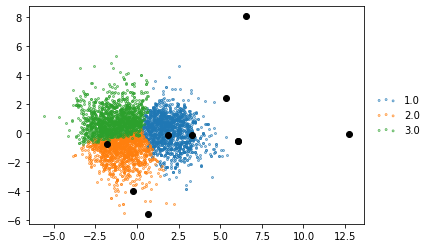

In [34]:
#Outliers according to LOF
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(clf.negative_outlier_factor_)[:10])

LOF is not suitable for finding samples with high aleatoric uncertainty in a region between two or more classes

### Accuracy as a function of the number of samples taken

Let us sort the samples by increasing measure of uncertainty (entropy, standard deviation, -log of highest probability and LOF score). The purpose is to find out whether we may isolate samples with high uncertainty (anomalies) that are more likely misclassified. They may be manually investigated afterwards.

In [35]:
Var_sort = np.argsort(np.mean(sd,axis=1))
S_sort = np.argsort(S)
nll_sort = np.argsort(NLL)
lof_sort = np.argsort(-clf.negative_outlier_factor_)

In [36]:
N_max = X_test.shape[0]
acc_sd = []
acc_S = []
acc_nll = []
acc_lof = []
range_samples = []
for i in range(int(0.01*N_max),N_max):
    acc_sd.append(accuracy_score(np.argmax(pred_mean[Var_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[Var_sort[:i]],axis=1)))
    
    acc_S.append(accuracy_score(np.argmax(pred_mean[S_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[S_sort[:i]],axis=1)))
    
    acc_nll.append(accuracy_score(np.argmax(pred_mean[nll_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[nll_sort[:i]],axis=1)))
    
    acc_lof.append(accuracy_score(np.argmax(pred_mean[lof_sort[:i]],axis=1),
                            np.argmax(y_test_onehot[lof_sort[:i]],axis=1)))
    range_samples.append(100*i/N_max)
    

(95.0, 100.0)

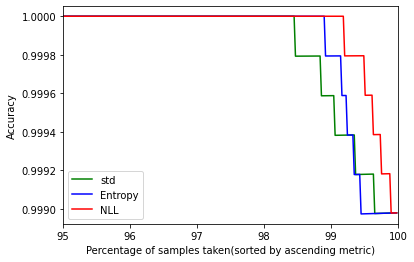

In [37]:
plt.plot(range_samples,acc_sd,'g')
plt.plot(range_samples,acc_S,'b')
plt.plot(range_samples,acc_nll,'r')
#plt.plot(range_samples,acc_nof,'k')
plt.legend(['std','Entropy','NLL','Local Outlier Factor'])
plt.xlabel('Percentage of samples taken(sorted by ascending metric)')
plt.ylabel('Accuracy')
plt.xlim([95,100])

Text(0.5, 0, 'Percentage of samples taken(sorted by LOF score)')

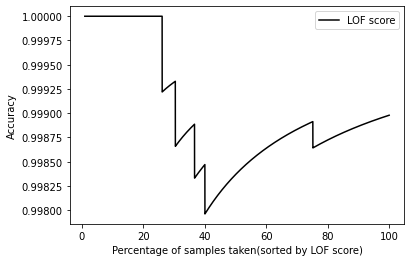

In [38]:
#plt.plot(range_samples,acc_nof,'k')
plt.plot(range_samples,acc_lof,'k')
plt.legend(['LOF score'])
plt.ylabel('Accuracy')
plt.xlabel('Percentage of samples taken(sorted by LOF score)')

LOF is again not suitable to work out anomalies in classification tasks